# <div style="text-align: center">Case study - Paul Jacques<div>

In [1]:
#basic libraries
import pandas as pd
import numpy as np
import ast

#libraries for feature reduction & preprocession
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#libraries for the models
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report,confusion_matrix, precision_recall_fscore_support
from pandas_ml import ConfusionMatrix

#libraries for ploting
import seaborn as sns
import matplotlib.pyplot as plt

#to calculate time of code shell
import time

#to make the notebook look prettier
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_rows = 450
pd.options.display.max_columns = 450


# Introduction

<div style="text-align: justify">The given dataset represents WIFI probe requests with a specific strength (values of the fr_values dictionaries) sent from 19 unique smartphones (represented by fr_mac_address_id) at a specific time (represented by fr_observation_time) to a set of 261 nodes (represented by the keys in fr_values) displaid at a specific location. That specific location has been divided in 449 different areas (represented by zo_name). <div>

<div style="text-align: justify">The idea is to build a classifier that explains and predicts to which area is a Smartphone at a specific time given the different WIFI probe requests and their strengths. Also, you will notice that I voluntary removed the other variables from my explanatory variable set. Even though they could improve the model, my objective is to build a good classifier with the nodes informations.<div>

<div style="text-align: justify">However, unlike other classification tasks, here we want to predict 449 class. This makes the use of trees-based classifier obsolete. Nonetheless, we are lucky enough to have continuous data as explanatory variables in our dataset.<div>
<div style="text-align: justify">I will therefore run a K-Nearest-Neighbours algorithm over the 261 variables (each representing a unique node). Still in the optic of making the model computationally efficient, there is a need of feature reduction.<div>
<div style="text-align: justify">While I also tried LDA, the following notebook only displays code for PCA with 60 components as LDA was taking much more time to run for a similar output. Note that I also ran the KNN over the 261 variables and it did not significantly improved the model. <div>

# 1.Import data & EDA

In [2]:
df=pd.read_csv(r'/Users/pauljacques/Downloads/minodes_recruiting_challenge/data/fingerprints_gt_ver3.csv',sep=',')

In [3]:
df.head()

,fr_observation_time,fr_values,fr_mac_address_id,zo_name
0,2015-12-08 10:00:13,"{'12': '-69', '33': '-61', '128': '-68', '276'...",2002427,Zone 355
1,2015-12-08 10:00:13,"{'9': '-83', '13': '-67', '33': '-62', '101': ...",3192369,Zone 355
2,2015-12-08 10:00:14,"{'9': '-83', '10': '-77', '11': '-85', '12': '...",2002427,Zone 355
3,2015-12-08 10:00:14,"{'9': '-86', '10': '-83', '11': '-87', '12': '...",3192369,Zone 355
4,2015-12-08 10:00:15,"{'10': '-76', '11': '-86', '12': '-65', '13': ...",480806,Zone 355


In [4]:
print ('We have %d unique zo_name to classify.' %df.zo_name.nunique())

We have 449 unique zo_name to classify.


## 1.1.Explore target variable zo_name

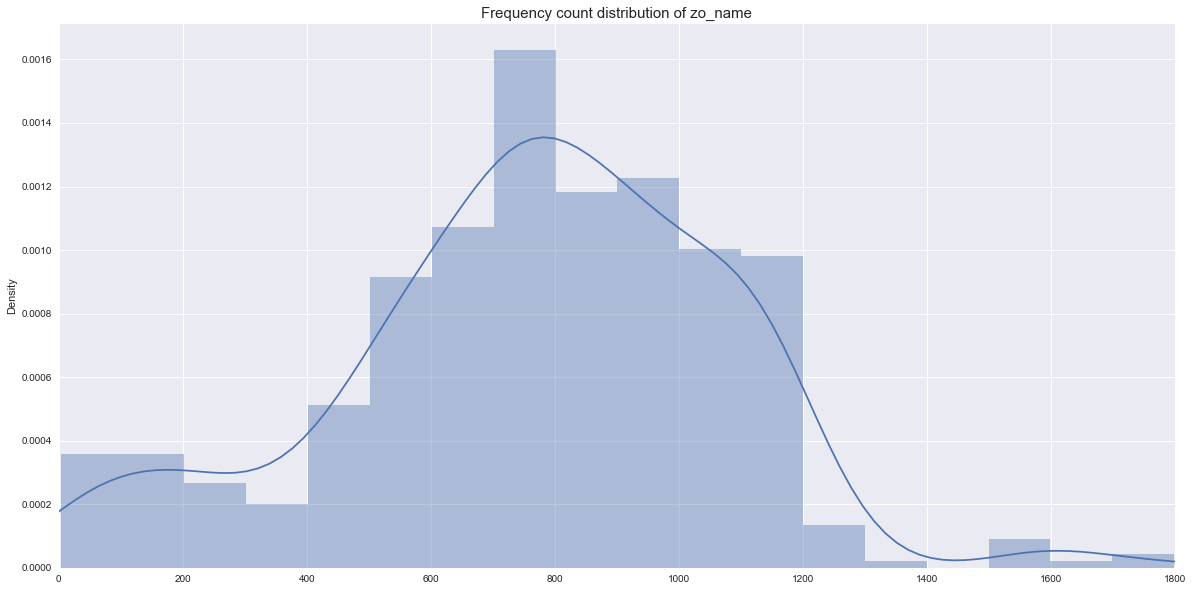

In [5]:
zo_name=np.array(df.zo_name.value_counts())  

plt.figure(figsize=(20,10))
sns.distplot(zo_name)
plt.xlim(xmin=0,xmax=1800)
plt.title('Frequency count distribution of zo_name',fontsize=15)
plt.ylabel('Density')
plt.show()

<div style="text-align: justify">As it is the case in many classification problems, we have an imbalanced distribution in our target variable, with a majority of zo_name appearing between 400 and 1200 times. A few quantity of zo_name appears less than 400 times, and even a fewer appears more than 1200 times. These zo_name on the right side of the distribution are the most popular areas of our dataset whereas those on the left side are 'marginal' areas.<div>

## 1.2.Transform fr_values

<div style="text-align: justify">The variable fr_values contains the node and signal strength of the device to that node for each fingerprints. I want to change the way the variable is displaid by having one serie representing one node with values of that serie representing the signal strength.<div>

In [6]:
#Convert string into a dictionary
df.fr_values=df.fr_values.apply(lambda x: ast.literal_eval(x))

In [7]:
#create set of all nodes
nodes=set()
for x in df.fr_values:
     for key in x:
            nodes.add(key)

print('We have %d nodes in total, which means 261 possible explanatory variables.'%(len(nodes)))

We have 261 nodes in total, which means 261 possible explanatory variables.


In [8]:
#Modify the dictionaries so they all contain each node
for x in df.fr_values:
     for i in nodes:
            if i in x:
                x[i]=int(x[i])
            else:
                x[i]=-100

In [9]:
#Transform the dictionaries to a new df, and column bind that new df with the original one, in df_1.
#The code takes some time, the transformation of a dictionary with 261 keys to a dataframe of 261 columns is expensive.
df_1=pd.concat([df['zo_name'].reset_index(drop=True),df.fr_values.apply(pd.Series)],axis=1)
df_1.head()

,zo_name,12,33,128,276,180,181,261,197,47,156,162,200,223,93,145,172,72,255,31,39,2,54,81,20,58,226,1,94,164,15,48,253,185,88,183,131,237,227,57,217,37,270,159,192,35,241,62,263,121,158,229,140,190,132,26,50,75,178,179,196,166,8,249,184,122,25,186,151,38,90,174,123,191,211,246,199,10,30,219,235,182,56,61,4,134,5,133,143,232,262,22,256,16,91,76,251,188,228,65,45,157,43,202,98,60,175,220,259,84,40,213,243,101,257,99,14,59,27,23,78,69,254,141,265,137,28,242,105,135,52,169,67,147,21,273,268,154,155,126,216,206,104,177,120,269,119,272,218,44,221,274,193,212,266,71,236,82,49,153,111,207,85,112,245,173,3,124,83,116,79,152,189,201,244,64,165,258,144,63,11,198,89,267,238,239,214,138,215,41,103,114,36,225,170,13,136,53,117,17,148,195,34,208,46,171,102,275,146,18,231,109,240,168,194,29,271,204,66,115,252,247,92,55,264,70,125,260,203,77,167,68,86,161,32,97,139,205,222,118,248,24,127,19,107,51,250,160,163,110,234,210,187,73,113,74,9,233,230,42,142,176
0,Zone 355,-69,-61,-68,-47,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
1,Zone 355,-100,-62,-73,-56,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-64,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-69,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-67,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-83,-100,-100,-100,-100,-100
2,Zone 355,-67,-65,-74,-48,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-69,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-68,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-77,-75,-100,-100,-100,-100,-100,-100,-10

# 2.Build the model: KNN with PCA

<div style="text-align: justify">Now that we have our variables displaid correctly we will need to do some feature reduction, as my machine would take forever (3 hours) to run a KNN on that many number of variables.<div>

## 2.1.Standardize the features

<div style="text-align: justify">Even though each node has its strength expressed in the same units it is good practice to standardized the values, as we could possibly expect nodes to perform differently and thus have different range of strength associated with it.<div>

In [10]:
features = list(df_1)
features.remove('zo_name')

x = df_1.loc[:, features].values
x = StandardScaler().fit_transform(x)

## 2.2.Run PCA and the model

<div style="text-align: justify">I choose the number of components by doing many trials. I started by running the KNN with all variables (so without PCA nor any feature reduction), which took approximately 3 hours on my machine. Then I decided to run a PCA, starting with a low number (5), and increasing the number as long as the results are improving without having an extraordinary long runtime. 60 components seemed to be the good compromise between a model performing almost as good as if I had kept all the variables and a model running in a decent amount of time (approx. 10 minutes).<div>

In [11]:
#Here I run the PCA for feature reduction, the pca_df represents the same data but in another dimensional space.
pca = PCA(n_components=60)
principalComponents = pca.fit_transform(x)
pca_df = pd.DataFrame(data = principalComponents)
pca_df = pd.concat([pca_df, df_1[['zo_name']]],axis=1)

In [12]:
#Here I define the KNN algorithm.
cv = StratifiedKFold(n_splits=3) #need to do maximum 3 folds as the class with the minimum frequency is 3

classifier_knn = KNeighborsClassifier(n_neighbors=15,weights='distance',algorithm='auto')

features = list(pca_df)
features.remove('zo_name')

x_=np.asarray(pca_df[features])
y_=np.asarray(pca_df['zo_name'])

In [13]:
#Here I run my model on a cross validation with 3 folds, and collect the evaluation metrics.
start=time.time()

labels=df_1['zo_name'].unique()

accuracy_pca=[]

f1_pca_micro=[]
f1_pca_macro=[]
f1_pca_weighted=[]

precision_pca_micro=[]
precision_pca_macro=[]
precision_pca_weighted=[]

recall_pca_micro=[]
recall_pca_macro=[]
recall_pca_weighted=[]

classification_report_=[]
confusion_matrices=[]

for train, test in cv.split(x_,y_):
        knn_clf=classifier_knn.fit(x_[train], y_[train])
        y_pred = knn_clf.predict(x_[test])
        accuracy_pca.append(knn_clf.score(x_[test],y_[test]))
        f1_pca_macro.append(f1_score(y_[test], y_pred, average="macro"))
        f1_pca_micro.append(f1_score(y_[test], y_pred, average="micro"))
        f1_pca_weighted.append(f1_score(y_[test], y_pred, average="weighted"))
        precision_pca_macro.append(precision_score(y_[test], y_pred, average="macro"))
        precision_pca_micro.append(precision_score(y_[test], y_pred, average="micro"))
        precision_pca_weighted.append(precision_score(y_[test], y_pred, average="weighted"))
        recall_pca_macro.append(recall_score(y_[test], y_pred, average="macro"))
        recall_pca_micro.append(recall_score(y_[test], y_pred, average="micro"))
        recall_pca_weighted.append(recall_score(y_[test], y_pred, average="weighted"))
        buffer=[]
        buffer.append(precision_recall_fscore_support(y_[test], y_pred, labels=labels))
        d={'precision':buffer[0][0],'recall':buffer[0][1],'f1-score':buffer[0][2],'support':buffer[0][3]}
        classification_report_.append(pd.DataFrame(data=d, index=labels))
        confusion_matrices.append(ConfusionMatrix(y_[test], y_pred).to_dataframe())
end=time.time()
print('The code took %d minutes to run' %((end-start)/60))

The code took 9 minutes to run


## 2.3.PCA evaluation metrics

### 2.3.1.Global metrics

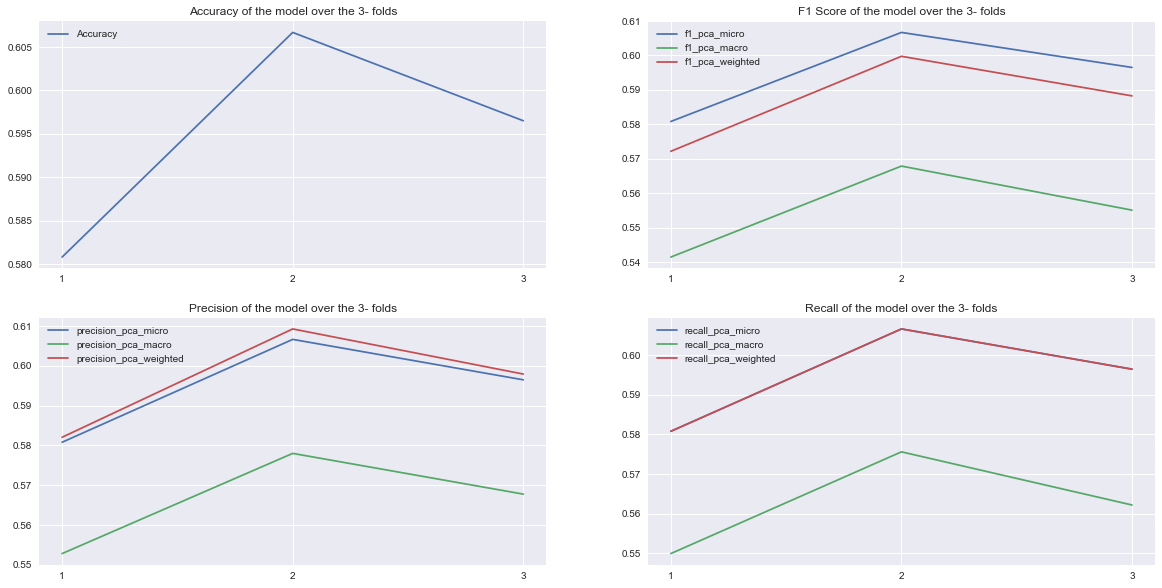

In [14]:
f, ax = plt.subplots(2,2,figsize=(20,10))
ax[0,0].plot(accuracy_pca,label='Accuracy')
ax[0,0].legend(loc='upper left')
ax[0,0].set_xticks(np.arange(3,step=1))
ax[0,0].set_xticklabels(('1','2','3'))
ax[0,0].set_title('Accuracy of the model over the 3- folds')
ax[0,1].plot(f1_pca_micro,label='f1_pca_micro')
ax[0,1].plot(f1_pca_macro,label='f1_pca_macro')
ax[0,1].plot(f1_pca_weighted,label='f1_pca_weighted')
ax[0,1].legend(loc='upper left')
ax[0,1].set_xticks(np.arange(3,step=1))
ax[0,1].set_xticklabels(('1','2','3'))
ax[0,1].set_title('F1 Score of the model over the 3- folds')
ax[1,0].plot(precision_pca_micro,label='precision_pca_micro')
ax[1,0].plot(precision_pca_macro,label='precision_pca_macro')
ax[1,0].plot(precision_pca_weighted,label='precision_pca_weighted')
ax[1,0].legend(loc='upper left')
ax[1,0].set_xticks(np.arange(3,step=1))
ax[1,0].set_xticklabels(('1','2','3'))
ax[1,0].set_title('Precision of the model over the 3- folds')
ax[1,1].plot(recall_pca_micro,label='recall_pca_micro')
ax[1,1].plot(recall_pca_macro,label='recall_pca_macro')
ax[1,1].plot(recall_pca_weighted,label='recall_pca_weighted')
ax[1,1].legend(loc='upper left')
ax[1,1].set_xticks(np.arange(3,step=1))
ax[1,1].set_xticklabels(('1','2','3'))
ax[1,1].set_title('Recall of the model over the 3- folds')

plt.show()

In [15]:
#Confusion matrice for CV1:
confusion_matrices[0].head()

Predicted,Zone 1,Zone 10,Zone 100,Zone 101,Zone 102,Zone 103,Zone 104,Zone 105,Zone 106,Zone 107,Zone 108,Zone 109,Zone 11,Zone 110,Zone 111,Zone 112,Zone 113,Zone 114,Zone 115,Zone 116,Zone 117,Zone 118,Zone 119,Zone 12,Zone 120,Zone 121,Zone 122,Zone 123,Zone 13,Zone 132,Zone 138,Zone 139,Zone 14,Zone 140,Zone 145,Zone 15,Zone 153,Zone 16,Zone 17,Zone 178,Zone 179,Zone 18,Zone 180,Zone 181,Zone 182,Zone 183,Zone 184,Zone 185,Zone 186,Zone 187,Zone 188,Zone 189,Zone 19,Zone 190,Zone 191,Zone 192,Zone 193,Zone 194,Zone 195,Zone 196,Zone 197,Zone 198,Zone 199,Zone 2,Zone 20,Zone 200,Zone 201,Zone 202,Zone 203,Zone 204,Zone 205,Zone 206,Zone 207,Zone 208,Zone 209,Zone 21,Zone 210,Zone 211,Zone 212,Zone 213,Zone 214,Zone 215,Zone 216,Zone 217,Zone 218,Zone 219,Zone 22,Zone 220,Zone 221,Zone 222,Zone 223,Zone 224,Zone 225,Zone 226,Zone 227,Zone 228,Zone 229,Zone 23,Zone 230,Zone 231,Zone 232,Zone 233,Zone 234,Zone 235,Zone 24,Zone 240,Zone 241,Zone 242,Zone 247,Zone 249,Zone 25,Zone 250,Zone 251,Zone 252,Zone 253,Zone 254,Zone 255,Zone 256,Zone 257,Zone 258,Zone 259,Zone 26,Zone 260,Zone 262,Zone 263,Zone 265,Zone 267,Zone 268,Zone 269,Zone 27,Zone 270,Zone 272,Zone 273,Zone 274,Zone 275,Zone 276,Zone 277,Zone 278,Zone 279,Zone 28,Zone 280,Zone 281,Zone 282,Zone 283,Zone 284,Zone 285,Zone 286,Zone 287,Zone 289,Zone 29,Zone 290,Zone 291,Zone 292,Zone 293,Zone 294,Zone 295,Zone 296,Zone 297,Zone 298,Zone 299,Zone 3,Zone 30,Zone 300,Zone 301,Zone 302,Zone 303,Zone 304,Zone 305,Zone 306,Zone 307,Zone 309,Zone 31,Zone 310,Zone 311,Zone 312,Zone 313,Zone 314,Zone 315,Zone 316,Zone 317,Zone 318,Zone 319,Zone 32,Zone 320,Zone 321,Zone 322,Zone 323,Zone 324,Zone 325,Zone 326,Zone 327,Zone 328,Zone 329,Zone 33,Zone 330,Zone 331,Zone 332,Zone 333,Zone 334,Zone 335,Zone 336,Zone 337,Zone 338,Zone 339,Zone 34,Zone 340,Zone 341,Zone 342,Zone 344,Zone 345,Zone 346,Zone 347,Zone 348,Zone 349,Zone 35,Zone 350,Zone 351,Zone 352,Zone 353,Zone 354,Zone 355,Zone 356,Zone 36,Zone 363,Zone 365,Zone 366,Zone 367,Zone 368,Zone 369,Zone 37,Zone 370,Zone 371,Zone 372,Zone 373,Zone 374,Zone 375,Zone 376,Zone 377,Zone 378,Zone 379,Zone 38,Zone 380,Zone 381,Zone 382,Zone 383,Zone 384,Zone 39,Zone 4,Zone 40,Zone 401,Zone 402,Zone 403,Zone 404,Zone 408,Zone 409,Zone 41,Zone 410,Zone 411,Zone 412,Zone 414,Zone 415,Zone 418,Zone 419,Zone 42,Zone 420,Zone 421,Zone 422,Zone 423,Zone 424,Zone 425,Zone 426,Zone 427,Zone 428,Zone 429,Zone 430,Zone 432,Zone 433,Zone 434,Zone 435,Zone 436,Zone 437,Zone 438,Zone 439,Zone 44,Zone 440,Zone 441,Zone 442,Zone 444,Zone 445,Zone 446,Zone 447,Zone 448,Zone 449,Zone 45,Zone 450,Zone 451,Zone 452,Zone 453,Zone 454,Zone 455,Zone 456,Zone 457,Zone 458,Zone 459,Zone 46,Zone 460,Zone 461,Zone 462,Zone 463,Zone 464,Zone 465,Zone 466,Zone 467,Zone 468,Zone 469,Zone 47,Zone 470,Zone 471,Zone 472,Zone 473,Zone 474,Zone 475,Zone 476,Zone 477,Zone 478,Zone 479,Zone 48,Zone 480,Zone 485,Zone 486,Zone 487,Zone 488,Zone 489,Zone 49,Zone 490,Zone 491,Zone 492,Zone 493,Zone 494,Zone 495,Zone 496,Zone 497,Zone 498,Zone 499,Zone 5,Zone 50,Zone 500,Zone 501,Zone 502,Zone 503,Zone 504,Zone 505,Zone 506,Zone 507,Zone 508,Zone 509,Zone 51,Zone 510,Zone 511,Zone 512,Zone 513,Zone 514,Zone 515,Zone 516,Zone 517,Zone 518,Zone 519,Zone 52,Zone 520,Zone 521,Zone 522,Zone 523,Zone 524,Zone 525,Zone 526,Zone 527,Zone 53,Zone 54,Zone 546,Zone 548,Zone 549,Zone 55,Zone 550,Zone 551,Zone 552,Zone 553,Zone 554,Zone 555,Zone 556,Zone 557,Zone 558,Zone 559,Zone 56,Zone 560,Zone 561,Zone 562,Zone 563,Zone 564,Zone 565,Zone 566,Zone 57,Zone 58,Zone 59,Zone 6,Zone 60,Zone 603,Zone 61,Zone 611,Zone 618,Zone 62,Zone 63,Zone 64,Zone 65,Zone 66,Zone 67,Zone 68,Zone 69,Zone 7,Zone 70,Zone 71,Zone 72,Zone 73,Zone 74,Zone 75,Zone 76,Zone 77,Zone 78,Zone 79,Zone 8,Zone 80,Zone 81,Zone 82,Zone 83,Zone 84,Zone 85,Zone 86,Zone 87,Zone 88,Zone 89,Zone 9,Zone 90,Zone 91,Zone 92,Zone 93,Zone 94,Zone 95,Zone 96,Zone 97,Zone 98
Actual,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [16]:
#Confusion matrice for CV2:
confusion_matrices[1].head()

Predicted,Zone 1,Zone 10,Zone 100,Zone 101,Zone 102,Zone 103,Zone 104,Zone 105,Zone 106,Zone 107,Zone 108,Zone 109,Zone 11,Zone 110,Zone 111,Zone 112,Zone 113,Zone 114,Zone 115,Zone 116,Zone 117,Zone 118,Zone 119,Zone 12,Zone 120,Zone 121,Zone 122,Zone 123,Zone 13,Zone 132,Zone 138,Zone 139,Zone 14,Zone 140,Zone 145,Zone 15,Zone 153,Zone 16,Zone 17,Zone 178,Zone 179,Zone 18,Zone 180,Zone 181,Zone 182,Zone 183,Zone 184,Zone 185,Zone 186,Zone 187,Zone 188,Zone 189,Zone 19,Zone 190,Zone 191,Zone 192,Zone 193,Zone 194,Zone 195,Zone 196,Zone 197,Zone 198,Zone 199,Zone 2,Zone 20,Zone 200,Zone 201,Zone 202,Zone 203,Zone 204,Zone 205,Zone 206,Zone 207,Zone 208,Zone 209,Zone 21,Zone 210,Zone 211,Zone 212,Zone 213,Zone 214,Zone 215,Zone 216,Zone 217,Zone 218,Zone 219,Zone 22,Zone 220,Zone 221,Zone 222,Zone 223,Zone 224,Zone 225,Zone 226,Zone 227,Zone 228,Zone 229,Zone 23,Zone 230,Zone 231,Zone 232,Zone 233,Zone 234,Zone 235,Zone 24,Zone 240,Zone 241,Zone 242,Zone 247,Zone 249,Zone 25,Zone 250,Zone 251,Zone 252,Zone 253,Zone 254,Zone 255,Zone 256,Zone 257,Zone 258,Zone 259,Zone 26,Zone 260,Zone 262,Zone 263,Zone 265,Zone 267,Zone 268,Zone 269,Zone 27,Zone 270,Zone 272,Zone 273,Zone 274,Zone 275,Zone 276,Zone 277,Zone 278,Zone 279,Zone 28,Zone 280,Zone 281,Zone 282,Zone 283,Zone 284,Zone 285,Zone 286,Zone 287,Zone 289,Zone 29,Zone 290,Zone 291,Zone 292,Zone 293,Zone 294,Zone 295,Zone 296,Zone 297,Zone 298,Zone 299,Zone 3,Zone 30,Zone 300,Zone 301,Zone 302,Zone 303,Zone 304,Zone 305,Zone 306,Zone 307,Zone 309,Zone 31,Zone 310,Zone 311,Zone 312,Zone 313,Zone 314,Zone 315,Zone 316,Zone 317,Zone 318,Zone 319,Zone 32,Zone 320,Zone 321,Zone 322,Zone 323,Zone 324,Zone 325,Zone 326,Zone 327,Zone 328,Zone 329,Zone 33,Zone 330,Zone 331,Zone 332,Zone 333,Zone 334,Zone 335,Zone 336,Zone 337,Zone 338,Zone 339,Zone 34,Zone 340,Zone 341,Zone 342,Zone 344,Zone 345,Zone 346,Zone 347,Zone 348,Zone 349,Zone 35,Zone 350,Zone 351,Zone 352,Zone 353,Zone 354,Zone 355,Zone 356,Zone 36,Zone 363,Zone 365,Zone 366,Zone 367,Zone 368,Zone 369,Zone 37,Zone 370,Zone 371,Zone 372,Zone 373,Zone 374,Zone 375,Zone 376,Zone 377,Zone 378,Zone 379,Zone 38,Zone 380,Zone 381,Zone 382,Zone 383,Zone 384,Zone 39,Zone 4,Zone 40,Zone 401,Zone 402,Zone 403,Zone 404,Zone 408,Zone 409,Zone 41,Zone 410,Zone 411,Zone 412,Zone 414,Zone 415,Zone 418,Zone 419,Zone 42,Zone 420,Zone 421,Zone 422,Zone 423,Zone 424,Zone 425,Zone 426,Zone 427,Zone 428,Zone 429,Zone 430,Zone 432,Zone 433,Zone 434,Zone 435,Zone 436,Zone 437,Zone 438,Zone 439,Zone 44,Zone 440,Zone 441,Zone 442,Zone 444,Zone 445,Zone 446,Zone 447,Zone 448,Zone 449,Zone 45,Zone 450,Zone 451,Zone 452,Zone 453,Zone 454,Zone 455,Zone 456,Zone 457,Zone 458,Zone 459,Zone 46,Zone 460,Zone 461,Zone 462,Zone 463,Zone 464,Zone 465,Zone 466,Zone 467,Zone 468,Zone 469,Zone 47,Zone 470,Zone 471,Zone 472,Zone 473,Zone 474,Zone 475,Zone 476,Zone 477,Zone 478,Zone 479,Zone 48,Zone 480,Zone 485,Zone 486,Zone 487,Zone 488,Zone 489,Zone 49,Zone 490,Zone 491,Zone 492,Zone 493,Zone 494,Zone 495,Zone 496,Zone 497,Zone 498,Zone 499,Zone 5,Zone 50,Zone 500,Zone 501,Zone 502,Zone 503,Zone 504,Zone 505,Zone 506,Zone 507,Zone 508,Zone 509,Zone 51,Zone 510,Zone 511,Zone 512,Zone 513,Zone 514,Zone 515,Zone 516,Zone 517,Zone 518,Zone 519,Zone 52,Zone 520,Zone 521,Zone 522,Zone 523,Zone 524,Zone 525,Zone 526,Zone 527,Zone 53,Zone 54,Zone 546,Zone 548,Zone 549,Zone 55,Zone 550,Zone 551,Zone 552,Zone 553,Zone 554,Zone 555,Zone 556,Zone 557,Zone 558,Zone 559,Zone 56,Zone 560,Zone 561,Zone 562,Zone 563,Zone 564,Zone 565,Zone 566,Zone 57,Zone 58,Zone 59,Zone 6,Zone 60,Zone 603,Zone 61,Zone 611,Zone 618,Zone 62,Zone 63,Zone 64,Zone 65,Zone 66,Zone 67,Zone 68,Zone 69,Zone 7,Zone 70,Zone 71,Zone 72,Zone 73,Zone 74,Zone 75,Zone 76,Zone 77,Zone 78,Zone 79,Zone 8,Zone 80,Zone 81,Zone 82,Zone 83,Zone 84,Zone 85,Zone 86,Zone 87,Zone 88,Zone 89,Zone 9,Zone 90,Zone 91,Zone 92,Zone 93,Zone 94,Zone 95,Zone 96,Zone 97,Zone 98
Actual,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [17]:
#Confusion matrice for CV3:
confusion_matrices[2].head()

Predicted,Zone 1,Zone 10,Zone 100,Zone 101,Zone 102,Zone 103,Zone 104,Zone 105,Zone 106,Zone 107,Zone 108,Zone 109,Zone 11,Zone 110,Zone 111,Zone 112,Zone 113,Zone 114,Zone 115,Zone 116,Zone 117,Zone 118,Zone 119,Zone 12,Zone 120,Zone 121,Zone 122,Zone 123,Zone 13,Zone 132,Zone 138,Zone 139,Zone 14,Zone 140,Zone 145,Zone 15,Zone 153,Zone 16,Zone 17,Zone 178,Zone 179,Zone 18,Zone 180,Zone 181,Zone 182,Zone 183,Zone 184,Zone 185,Zone 186,Zone 187,Zone 188,Zone 189,Zone 19,Zone 190,Zone 191,Zone 192,Zone 193,Zone 194,Zone 195,Zone 196,Zone 197,Zone 198,Zone 199,Zone 2,Zone 20,Zone 200,Zone 201,Zone 202,Zone 203,Zone 204,Zone 205,Zone 206,Zone 207,Zone 208,Zone 209,Zone 21,Zone 210,Zone 211,Zone 212,Zone 213,Zone 214,Zone 215,Zone 216,Zone 217,Zone 218,Zone 219,Zone 22,Zone 220,Zone 221,Zone 222,Zone 223,Zone 224,Zone 225,Zone 226,Zone 227,Zone 228,Zone 229,Zone 23,Zone 230,Zone 231,Zone 232,Zone 233,Zone 234,Zone 235,Zone 24,Zone 240,Zone 241,Zone 242,Zone 247,Zone 249,Zone 25,Zone 250,Zone 251,Zone 252,Zone 253,Zone 254,Zone 255,Zone 256,Zone 257,Zone 258,Zone 259,Zone 26,Zone 260,Zone 262,Zone 263,Zone 265,Zone 267,Zone 268,Zone 269,Zone 27,Zone 270,Zone 272,Zone 273,Zone 274,Zone 275,Zone 276,Zone 277,Zone 278,Zone 279,Zone 28,Zone 280,Zone 281,Zone 282,Zone 283,Zone 284,Zone 285,Zone 286,Zone 287,Zone 289,Zone 29,Zone 290,Zone 291,Zone 292,Zone 293,Zone 294,Zone 295,Zone 296,Zone 297,Zone 298,Zone 299,Zone 3,Zone 30,Zone 300,Zone 301,Zone 302,Zone 303,Zone 304,Zone 305,Zone 306,Zone 307,Zone 309,Zone 31,Zone 310,Zone 311,Zone 312,Zone 313,Zone 314,Zone 315,Zone 316,Zone 317,Zone 318,Zone 319,Zone 32,Zone 320,Zone 321,Zone 322,Zone 323,Zone 324,Zone 325,Zone 326,Zone 327,Zone 328,Zone 329,Zone 33,Zone 330,Zone 331,Zone 332,Zone 333,Zone 334,Zone 335,Zone 336,Zone 337,Zone 338,Zone 339,Zone 34,Zone 340,Zone 341,Zone 342,Zone 344,Zone 345,Zone 346,Zone 347,Zone 348,Zone 349,Zone 35,Zone 350,Zone 351,Zone 352,Zone 353,Zone 354,Zone 355,Zone 356,Zone 36,Zone 363,Zone 365,Zone 366,Zone 367,Zone 368,Zone 369,Zone 37,Zone 370,Zone 371,Zone 372,Zone 373,Zone 374,Zone 375,Zone 376,Zone 377,Zone 378,Zone 379,Zone 38,Zone 380,Zone 381,Zone 382,Zone 383,Zone 384,Zone 39,Zone 4,Zone 40,Zone 401,Zone 402,Zone 403,Zone 404,Zone 408,Zone 409,Zone 41,Zone 410,Zone 411,Zone 412,Zone 414,Zone 415,Zone 418,Zone 419,Zone 42,Zone 420,Zone 421,Zone 422,Zone 423,Zone 424,Zone 425,Zone 426,Zone 427,Zone 428,Zone 429,Zone 430,Zone 432,Zone 433,Zone 434,Zone 435,Zone 436,Zone 437,Zone 438,Zone 439,Zone 44,Zone 440,Zone 441,Zone 442,Zone 444,Zone 445,Zone 446,Zone 447,Zone 448,Zone 449,Zone 45,Zone 450,Zone 451,Zone 452,Zone 453,Zone 454,Zone 455,Zone 456,Zone 457,Zone 458,Zone 459,Zone 46,Zone 460,Zone 461,Zone 462,Zone 463,Zone 464,Zone 465,Zone 466,Zone 467,Zone 468,Zone 469,Zone 47,Zone 470,Zone 471,Zone 472,Zone 473,Zone 474,Zone 475,Zone 476,Zone 477,Zone 478,Zone 479,Zone 48,Zone 480,Zone 485,Zone 486,Zone 487,Zone 488,Zone 489,Zone 49,Zone 490,Zone 491,Zone 492,Zone 493,Zone 494,Zone 495,Zone 496,Zone 497,Zone 498,Zone 499,Zone 5,Zone 50,Zone 500,Zone 501,Zone 502,Zone 503,Zone 504,Zone 505,Zone 506,Zone 507,Zone 508,Zone 509,Zone 51,Zone 510,Zone 511,Zone 512,Zone 513,Zone 514,Zone 515,Zone 516,Zone 517,Zone 518,Zone 519,Zone 52,Zone 520,Zone 521,Zone 522,Zone 523,Zone 524,Zone 525,Zone 526,Zone 527,Zone 53,Zone 54,Zone 546,Zone 548,Zone 549,Zone 55,Zone 550,Zone 551,Zone 552,Zone 553,Zone 554,Zone 555,Zone 556,Zone 557,Zone 558,Zone 559,Zone 56,Zone 560,Zone 561,Zone 562,Zone 563,Zone 564,Zone 565,Zone 566,Zone 57,Zone 58,Zone 59,Zone 6,Zone 60,Zone 603,Zone 61,Zone 611,Zone 618,Zone 62,Zone 63,Zone 64,Zone 65,Zone 66,Zone 67,Zone 68,Zone 69,Zone 7,Zone 70,Zone 71,Zone 72,Zone 73,Zone 74,Zone 75,Zone 76,Zone 77,Zone 78,Zone 79,Zone 8,Zone 80,Zone 81,Zone 82,Zone 83,Zone 84,Zone 85,Zone 86,Zone 87,Zone 88,Zone 89,Zone 9,Zone 90,Zone 91,Zone 92,Zone 93,Zone 94,Zone 95,Zone 96,Zone 97,Zone 98
Actual,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

### 2.3.2.Metrics per area

In [18]:
#Create a dataframe with average score over the 3 folds for each zo_name in order to have better visualisations
classification_report_[0].columns=['precision_CV1','recall_CV1','f1-score_CV1','support_CV1']
classification_report_[1].columns=['precision_CV2','recall_CV2','f1-score_CV2','support_CV2']
classification_report_[2].columns=['precision_CV3','recall_CV3','f1-score_CV3','support_CV3']

classification_avg=pd.DataFrame()
classification_all=pd.concat([classification_report_[0],classification_report_[1],classification_report_[2]],axis=1)
classification_avg['precision_avg']=classification_all[['precision_CV1', 'precision_CV2','precision_CV3']].mean(axis=1)
classification_avg['recall_avg']=classification_all[['recall_CV1', 'recall_CV2','recall_CV3']].mean(axis=1)
classification_avg['f1-score_avg']=classification_all[['f1-score_CV1', 'f1-score_CV2','f1-score_CV3']].mean(axis=1)

In [19]:
#Use this function to compare some areas, and have the output as a dataframe
def compare_areas(*args):
        areas=pd.DataFrame([classification_avg.loc[x] for x in args])
        return (areas)

In [20]:
#Call as many zones as you want (be reasonable! :D)
compare_areas('Zone 51','Zone 2')

,precision_avg,recall_avg,f1-score_avg
Zone 51,0.902675,0.903742,0.902899
Zone 2,0.358927,0.341659,0.349408


In [21]:
#Use this function to compare some areas, and have the output as a plot
def plot_areas(*args):
    d_precision={}
    d_recall={}
    d_f1={}
    f, ax = plt.subplots(2,2,figsize=(20,10))
    for x in args:
        d_precision[x]=np.array([classification_report_[0].loc[x,'precision_CV1'],
                                 classification_report_[1].loc[x,'precision_CV2'],
                                 classification_report_[2].loc[x,'precision_CV3']])
        d_recall[x]=np.array([classification_report_[0].loc[x,'recall_CV1'],
                              classification_report_[1].loc[x,'recall_CV2'],
                              classification_report_[2].loc[x,'recall_CV3']])
        d_f1[x]=np.array([classification_report_[0].loc[x,'f1-score_CV1'],
                          classification_report_[1].loc[x,'f1-score_CV2'],
                          classification_report_[2].loc[x,'f1-score_CV3']])
    for key in d_precision:
        ax[0,0].plot(d_precision[key],label=key)
        ax[0,1].plot(d_recall[key],label=key)
        ax[1,0].plot(d_f1[key],label=key)
    ax[0,0].legend(loc='upper left')
    ax[0,0].set_xticks(np.arange(3,step=1))
    ax[0,0].set_xticklabels(('1','2','3'))
    ax[0,0].set_title('Precision for each Zone over the 3- folds')
    ax[0,1].legend(loc='upper left')
    ax[0,1].set_xticks(np.arange(3,step=1))
    ax[0,1].set_xticklabels(('1','2','3'))
    ax[0,1].set_title('Recall for each Zone over the 3- folds')
    ax[1,0].legend(loc='upper left')
    ax[1,0].set_xticks(np.arange(3,step=1))
    ax[1,0].set_xticklabels(('1','2','3'))
    ax[1,0].set_title('F1-score for each Zone over the 3- folds')
    f.delaxes(plt.subplot(2,2,4))
    plt.show()

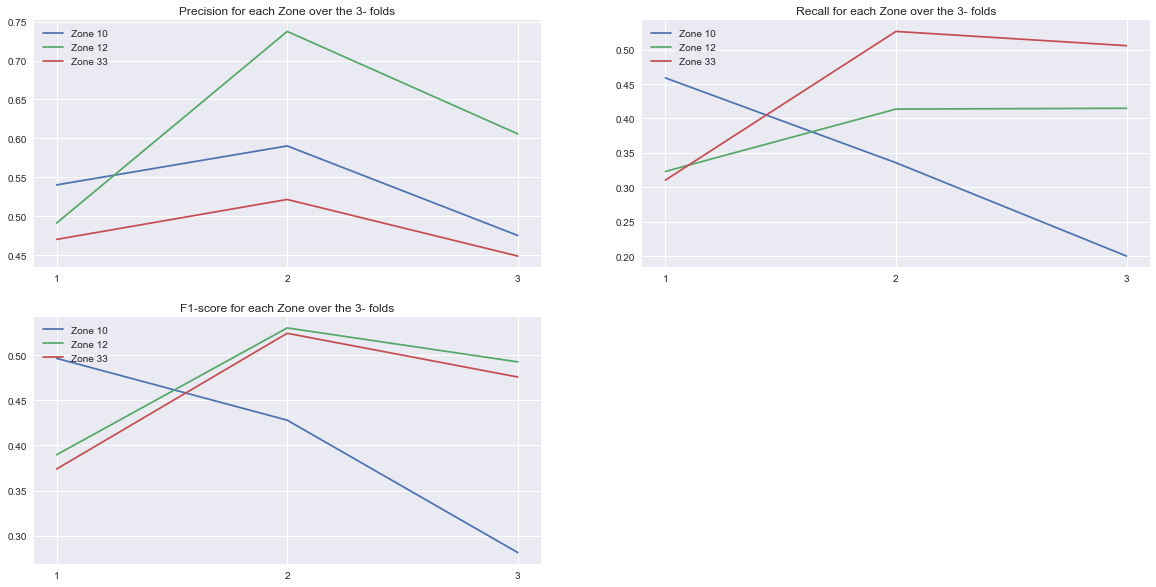

In [22]:
#Call as many zones as you want (be reasonable! :D)
plot_areas('Zone 10' , 'Zone 12','Zone 33')

### 2.3.3.Understanding the results

<div style="text-align: justify"> Here I want to see if some zo_name are better classified according to their frequency, assuming the most represented areas are the best classified.<div>

In [23]:
conclu=pd.concat([classification_avg,df.zo_name.value_counts()],axis=1)

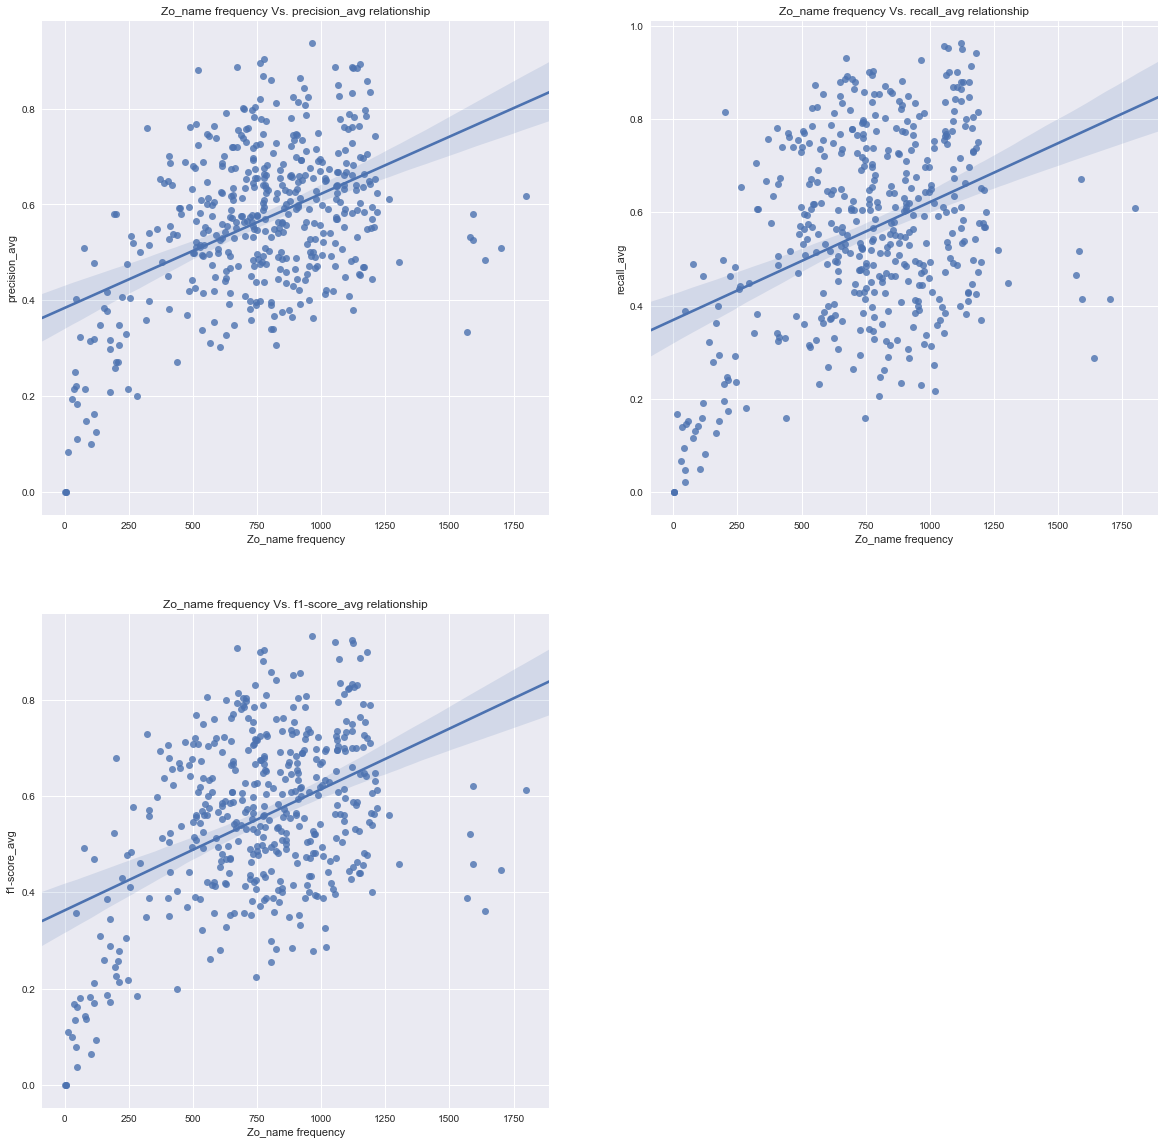

In [24]:
score_var=list(conclu.select_dtypes(include=['float']))

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,20))
for idx, var in enumerate(score_var):
    ax_coord = plt.subplot(2, 2, idx+1)
    sns.regplot(x="zo_name", y=var, data=conclu)
    ax_coord.set_title('Zo_name frequency Vs. %s relationship'% var)
    ax_coord.set_xlabel('Zo_name frequency')
    ax_coord.set_ylabel(var)
    fig.delaxes(plt.subplot(2,2,4))
plt.show()

<div style="text-align: justify"> There is a strong relationship between the frequency of an area and its classification scores. However there still is a lot of variance amongst frequent areas. <div>

# Conclusion

<div style="text-align: justify"> I used KNN because it seemed to be the most appropriate algorithm to use for that specific classification task. I assumed that each zone was geographically within the same area, thus each area could be plotted according to its distance (strength of the signal) to each nodes. However:
  - It could be that each zones are not necessarily in the same geographic area, thus making the KNN algorithm less relevant to use
  - Strength of a signal could vary from one device to the other, and thus react differently toward each node.
<div>